In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pathlib
import pandas as pd
import tensorflow as tf

import pickle
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,BatchNormalization,Concatenate,Conv2D,AveragePooling2D
from tensorflow.keras.models import Model
import datetime
from tensorflow.keras.regularizers import l2
from PIL import Image, ImageDraw
from PIL import ImagePath
from tensorflow.keras.optimizers import Adam,SGD

from tqdm import tqdm
import os
from tensorflow.keras.layers import Embedding
from IPython.display import Image as i
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,CSVLogger,LearningRateScheduler

import cv2
from numpy import expand_dims
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import urllib
import scipy.io

from enque import GeneratorEnqueuer
from Levenshtein import distance 
import imgaug.augmenters as iaa
import os
import math
from itertools import compress
# from shapely.geometry import Polygon
import time
import random
import threading
import multiprocessing
import config
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from utils import check_and_validate_polys, crop_area, rotate_image, generate_rbox,generate_r, get_project_matrix_and_width, sparse_tuple_from, crop_area_fix

In [2]:
def return_names(root_dir,str1):
    data_root = pathlib.Path(root_dir)
    print("root is",data_root)
    all_pics_path=list(data_root.glob("**/*."+ str1))
    all_pics_path=[str(path) for path in all_pics_path]
    dict1={str1: all_pics_path}

    data_df=pd.DataFrame(dict1)
    return data_df

In [3]:
#https://github.com/Pay20Y/FOTS_TF/tree/dev/data_provider

# Get the image paths and along with labels and bounding boxes [ICDAR 15]

In [4]:
rdir='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_images'
icdar_2015=return_names(rdir,'JPG')
rdir_test='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_test_images\\'
icdar_2015_test=return_names(rdir_test,'JPG')

root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_images
root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_test_images


In [5]:
g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_localization_transcription_gt\\'
icdar_2015_gt=return_names(g,'txt')
g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\Challenge4_Test_Task1_GT\\'
icdar_2015_gt_test=return_names(g,'txt')

root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_localization_transcription_gt
root is C:\Users\Abhi\Desktop\CS2\icdar2015\Challenge4_Test_Task1_GT


In [6]:
train=pd.concat([icdar_2015,icdar_2015_gt],axis=1)

In [7]:
# data = ((image, rInput), (sm, gm, am, ..y_ture))

# Model():
#     call(self, data):
#         imagess, rInputs, 
#         // backone
#         // detection
#         // recognition(rInputs)
#         retun do, ro

# fit(loss=custom_loss)

# Custom_loss(yp, yt):
#     // rec loss(..)
#     // det loss(..)
    
#     return loss

# rec_loss(..)

In [7]:
list1=[]
for i in train['txt']:
    f = open(i, "r",encoding='utf-8')
    list1.append(f.readlines())
train['y']=list1
list5=[]
for i in train ['y']:
    list2=[]
    list3=[]
    for j in range(len(i)):
        if j ==0:
            list2.append(                      i[j][1:].split(',')[:-1])
          
            list3.append(i[j].split(',')[-1].replace('\n',''))
    
        else:
             list2.append(        i[j].split(',')[:-1])
             list3.append(i[j].split(',')[-1].replace('\n',''))
    list5.append((list2,list3))
train['label']=[i[1] for i in list5]
train['bb']=[i[0] for i in list5]
train[['label','bb']].head()

,label,bb
0,"[Genaxis Theatre, [06], ###, 62-03, Carpark, #...","[[377, 117, 463, 117, 465, 130, 378, 130], [49..."
1,"[###, HarbourFront, CC22, bua, ###, ###, ###, ...","[[261, 138, 284, 140, 279, 158, 260, 158], [28..."
2,"[Way, out, ###, Line, Platform, ###, ###, ###]","[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1..."
3,"[###, ###, ###, ###]","[[486, 216, 554, 211, 558, 243, 489, 248], [1,..."
4,"[CARE, STICKER, FOR, ###, MORE, ###, ###, ###,...","[[899, 214, 928, 213, 928, 241, 900, 242], [93..."


In [8]:
train.head(1)

,JPG,txt,y,label,bb
0,C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_traini...,C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_traini...,"[﻿377,117,463,117,465,130,378,130,Genaxis Thea...","[Genaxis Theatre, [06], ###, 62-03, Carpark, #...","[[377, 117, 463, 117, 465, 130, 378, 130], [49..."


# Exp

In [11]:
CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-~`´<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
def label_to_array(label):
    try:
        label = label.replace(' ', '')
        return [CHAR_VECTOR.index(x) for x in label]
    except Exception as ex:
        print(label)
        raise ex

def generator( input_size=512, batch_size=12,min_text_size=10):
    # data_loader = SynthTextLoader()
   
    # image_list = np.array(data_loader.get_images(FLAGS.training_data_dir))
    image_list = np.array(train['JPG'])
    gt=np.array(train['bb'])
    # print('{} training images in {} '.format(image_list.shape[0], FLAGS.training_data_dir))
    index = np.arange(0, image_list.shape[0])
    
#         np.random.shuffle(index)
    batch_images = []
    batch_image_fns = []
    batch_score_maps = []
    batch_geo_maps = []
    batch_training_masks = []

    batch_text_polyses = [] 
    batch_text_tagses = []
    batch_boxes_masks = []

    batch_text_labels = []
    rboxes = []
    count = 0
    for i in index:
            try:
                im_fn = image_list[i]
                im=cv2.imread(im_fn)
                vertexlist,w,h=gt[i],im.shape[1],im.shape[0]
               
                list2=[]
                for j in range(len(vertexlist)):
                    list1=[]
                    k=0
                    while k<7:
                        list1.append((float(vertexlist[j][k]),float(vertexlist[j][k+1])))
                        k=k+2
                    list2.append(list1)
               
               


                text_tags=[]
                labels=[]
                for label in train['label'][i]:
                    if label == '*' or label == '###' or label == '':
                        text_tags.append(True)
                        labels.append([-1])
                    else:
                        labels.append(label_to_array(label))
                        text_tags.append(False)
                poly=np.array(list2)
                text_tags=np.array(text_tags)
               
                text_polys, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

                ############################# Data Augmentation ##############################
                # random scale this image
               
#                 scale=random.choice((.8,1,2))
#                 im = cv2.resize(im, dsize=None, fx=scale, fy=scale)
#                 text_polys = poly*scale
              
# #                 rotate image from [-10, 10
#                 angle=random.randint(-10,10)
#                 im, text_polys = rotate_image(im, text_polys, angle)
               
                # 600×600 random samples are cropped.
#                 im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
#                 # im, text_polys, text_tags, selected_poly = crop_area_fix(im, text_polys, text_tags, crop_size=(600, 600))
#                 text_labels = [text_labels[i] for i in selected_poly]
#                 if text_polys.shape[0] == 0 or len(text_labels) == 0:
#                     continue

                # pad the image to the training input size or the longer side of image
                new_h, new_w, _ = im.shape
                max_h_w_i = np.max([new_h, new_w, input_size])
                im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
                im_padded[:new_h, :new_w, :] = im.copy()
                im = im_padded
                # resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(resize_w, resize_h))
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask,rbox,rectangles = generate_r((new_h, new_w), text_polys, text_tags,min_text_size)
#                 mask = [not (word == [-1]) for word in text_labels]
#                 text_labels = list(compress(text_labels, mask))
#                 rectangles = list(compress(rectangles, mask))

                mask1 = [not (word == [-1]) for word in text_labels]
                mask2 = [j[1] > min_text_size and j[0] > min_text_size for j in [i[2::] for i in rbox[1]]]  # make sure the text is at least 4x4 pixels
                mask = [True if i and j else False for (i, j) in zip(mask1, mask2)]
                text_labels = list(compress(text_labels, mask))
                rectangles = list(compress(rectangles, mask))
                rbox = tuple([list(compress(item, mask)) for item in rbox])
              
                assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

                if len(text_labels) == 0:
                    continue

                boxes_mask = np.array([count] * len(rectangles))

                count += 1

                batch_images.append(im.astype(np.float32))
                
                batch_image_fns.append(im_fn)
                batch_score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                batch_geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                batch_training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))

                batch_text_polyses.append(rectangles)
                batch_boxes_masks.append(boxes_mask)
                batch_text_labels.extend(text_labels)
                batch_text_tagses.append(text_tags)
                rboxes.append(rbox)
                if len(batch_images) == batch_size:
                    batch_text_polyses = np.concatenate(batch_text_polyses)
                    batch_text_tagses = np.concatenate(batch_text_tagses)
                    batch_transform_matrixes, batch_box_widths = get_project_matrix_and_width(batch_text_polyses, batch_text_tagses)
                   
                    batch_text_labels_sparse = sparse_tuple_from(np.array(batch_text_labels))

                   # yield batch_images,  np.array([batch_transform_matrixes, batch_boxes_masks, batch_box_widths, batch_text_labels_sparse, batch_text_polyses, batch_text_labels,rboxes])
                    yield batch_images, batch_image_fns, batch_score_maps, batch_geo_maps, batch_training_masks, batch_transform_matrixes, batch_boxes_masks, batch_box_widths, batch_text_labels_sparse, batch_text_polyses, batch_text_labels,rboxes
                    batch_images = []
                    batch_image_fns = []
                    batch_score_maps = []
                    batch_geo_maps = []
                    batch_training_masks = []
                    batch_text_polyses = [] 
                    batch_text_tagses = []
                    batch_boxes_masks = []
                    batch_text_labels = []
                    rboxes=[]
                    count = 0
            except Exception as e:
                import traceback
              
                traceback.print_exc()
                continue

In [10]:
def get_batch(num_workers, **kwargs):
    try:
        enqueuer = GeneratorEnqueuer(generator(**kwargs), use_multiprocessing=False)
        enqueuer.start(max_queue_size=10, workers=num_workers)
        generator_output = None
        while True:
            while enqueuer.is_running():
                if not enqueuer.queue.empty():
                    generator_output = enqueuer.queue.get()
                    break
                else:
                    time.sleep(0.01)
            yield generator_output
            generator_output = None
    finally:
        if enqueuer is not None:
            enqueuer.stop()

In [26]:
data[2][0].shape

(128, 128, 1)

In [21]:
data[3][0].shape

(128, 128, 5)

In [44]:
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    #print(geometry.shape)
    d = geometry[:, :4]
    #print(d.shape)
    angle = geometry[:, 4]
    # for angle > 0
    #print(angle)
    # print((angle>=0).shape)
    #print(origin)
    origin_0 = origin[angle >= 0]
    #print(origin_0.shape)
    d_0 = d[angle >= 0]
    #print(d_0.shape)
    #print(d_0)
    angle_0 = angle[angle >= 0]
    #print(angle_0.shape)
    #print(-d_0[:, 0] - d_0[:, 2])
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        #print(p.shape)
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2
#         print(p.shape)

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        # print(p_rotate_x)
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
        #print(origin_0)
        #print(new_p_0)
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_
def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    #print(box)
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

import time

def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)

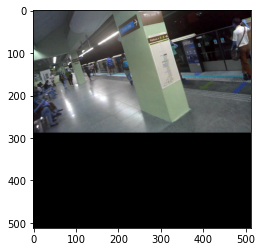

Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-143-c1362dae5958>", line 99, in generator
    score_map, geo_map, training_mask,rbox,rectangles = generate_r((new_h, new_w), text_polys, text_tags,min_text_size)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


In [152]:
plt.imshow(im/255)

In [192]:
im.shape

(512, 512, 3)

In [40]:
dg = get_batch(num_workers=1, input_size=512, batch_size=1,min_text_size=10)
data = next(dg)
im=data[0][0]
score_map=data[2][0][:,:,0]
geo_map=data[3][0]

In [50]:

def roi(im,score_map,geo_map):   
 
    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map
    score_map_thresh=0.2
    box_thresh=0.3
    nms_thres=0.1
    if len(score_map.shape) == 4:
   
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)

    # print(xy_text)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :])
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # boxes = cv2.dnn.NMSBoxes(boxes, score_map, 0.3, (0.1))

    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   
    #print(res)
    box_index = []
#     brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            # print(rbox)
            para = restore_roiRotatePara(rbox)
            #break
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[] 
    rois=[]
    print(len(rotateParas))
    if len(rotateParas) > 0:
        for num in range(len(rotateParas)):
            text=""
            out=[]
            out1=rotateParas[num][0]
            for f in out1 :
            
                if f <0:
                    f=-1*f
                out.append(f)
        
            crop=rotateParas[num][1]
            points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
            angle=rotateParas[num][2] 
                #print(out)
#                 img1=tf.image.crop_to_bounding_box(img,out[1]-(int(out[1]*(5/100))),out[0]-(int(out[0]*(5/100))),out[3]+(int(out[3]*(55/100))),out[2]+(int(out[2]*(55/100))))
                # print(out)
            img1=tf.image.crop_to_bounding_box(im,out[1],out[0],out[3],out[2])
                #print(img1.shape)
#                 plt.imshow(img1)
#                 plt.show()
            img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
                
                #print(crop)
                #print(crop[0])
            img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
#                 plt.imshow(img2)
#                 plt.show()
            img2=cv2.resize(img2,(256,60))
            img2=cv2.detailEnhance(img2)
#             img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            ret,thr = cv2.threshold(img2, 0, 255, cv2.THRESH_OTSU)
            rois.append(img2)
#         pred=recognizer.predict(thr[np.newaxis,:,:,np.newaxis])
#         pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((1),'int8')*64,)

#         x=''
#         for i in pred_arr[0][0][0]:
    
#             if i== -1:
#                 continue
#             else:
#                 x+=''.join(CHAR_VECTOR[i])
#         txt.append(x)
            pts.append(points) 
    return rois

In [52]:
g=roi(im,score_map,geo_map)

1


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\thresh.cpp:1557: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)


TypeError: Invalid shape (1, 60, 256) for image data

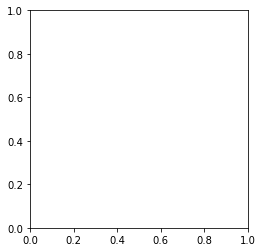

In [47]:
plt.imshow(g[0])

In [210]:
len(list1[1][0])

3

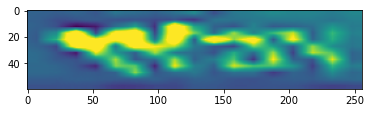

In [199]:
plt.imshow(g[0])

In [79]:
len(rotateParas)

3

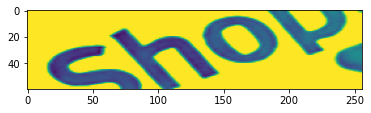

In [80]:
plt.imshow(img2)

In [81]:
len(rois)

3

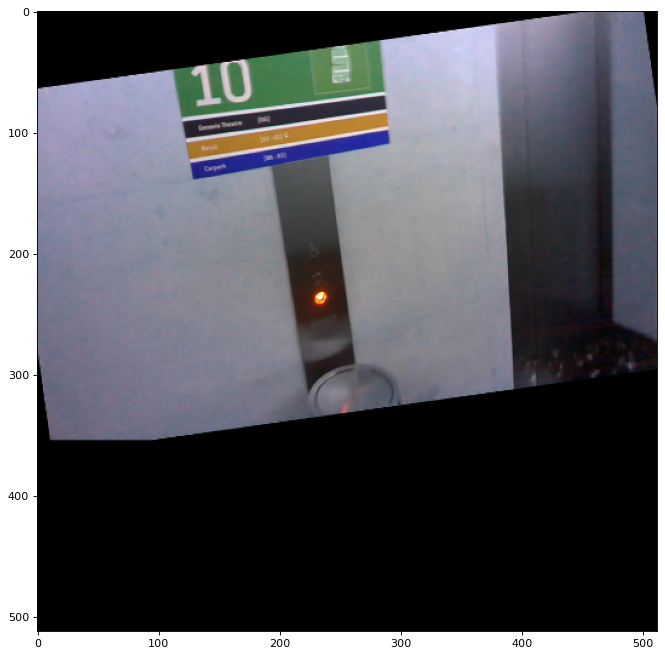

In [50]:
for i in range(len(txt)):
        
        
        cv2.polylines(im,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
#         cv2.putText(im,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
      

from matplotlib.pyplot import figure

figure(figsize=(10, 15), dpi=80)
    
plt.imshow(im/255)

In [ ]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
 
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self):
        
      
        
    
    def __getitem__(self, i):
        
        # read data
        iter=0
        dg = get_batch(num_workers=1, input_size=512, batch_size=1,min_text_size=1)
        images=[]
        image_mask=[]
        for j in dg:
            images.append(j[0])
            image_mask.append(j[1])
            iter+=1
        if iter>2:
            break
            
        
        
        
        
        # add background if mask is not binary
#         if image_mask.shape[-1] != 1:
#             background = 1 - image_mask.sum(axis=-1, keepdims=True)
        
#             image_mask = np.concatenate((image_mask, background), axis=-1)
            
        

        
        
        
#         image_mask=create_multi_mask(self.masks_fps[i]  )
        
       
        return image, image_mask
        
    def __len__(self):
        return traon['bb'].shape[0]
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=5, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


In [42]:
data[1][-2]

[[42, 14, 23, 10, 33, 18, 28, 55, 17, 14, 10, 29, 27, 14],
 [85, 0, 6, 86],
 [6, 2, 62, 0, 3],
 [38, 10, 27, 25, 10, 27, 20],
 [43, 10, 27, 11, 24, 30, 27, 41, 27, 24, 23, 29],
 [38, 38, 2, 2],
 [11, 30, 10],
 [58, 10, 34],
 [24, 30, 29],
 [47, 18, 23, 14],
 [51, 21, 10, 29, 15, 24, 27, 22],
 [38, 36, 53, 40],
 [54, 55, 44, 38, 46, 40, 53],
 [41, 50, 53],
 [48, 50, 53, 40],
 [54, 17, 24, 25],
 [39, 18, 23, 14],
 [54, 48, 53, 55],
 [16, 30, 10, 27, 13, 18, 10, 23],
 [37, 36, 42],
 [55, 43, 36, 49, 46],
 [60, 50, 56],
 [41, 50, 53],
 [52, 56, 40, 56, 40, 44, 49, 42],
 [38, 10, 23, 24, 23],
 [38, 36, 53, 39],
 [53, 40, 36, 39, 40, 53],
 [40, 59, 44, 55],
 [54, 44, 39, 40, 62, 42, 36, 55, 40],
 [53, 40, 54, 44, 39, 40, 49, 55, 54],
 [54, 38, 36, 49],
 [39, 40, 36, 53],
 [60, 50, 56, 53],
 [36, 38, 38, 40, 54, 54],
 [38, 36, 53, 39],
 [55, 43, 40],
 [55, 43, 40],
 [53, 44, 42, 43, 55],
 [43, 36, 49, 39],
 [54, 44, 39, 40],
 [55, 43, 40],
 [58, 36, 47, 47],
 [36, 49, 39],
 [50, 51, 40, 49],


In [48]:
dataset = tf.data.Dataset.from_generator(
    generator,
     (tf.float32,tf.float32))
dataset = dataset.cache()

In [ ]:
for i in dataset:
    print(i[1].shape)
    break

TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 139, in generator
    yield batch_images,  np.array([batch_transform_matrixes, batch_boxes_masks, batch_box_widths, batch_text_labels_sparse, batch_text_polyses, batch_text_labels,rboxes]).astype(np.float32)
ValueError: setting an array element with a sequence.
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    ba

Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray

Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray

CAFÉ


Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray' object has no attribute 'append'
Traceback (most recent call last):
  File "<ipython-input-46-71b66a850a62>", line 127, in generator
    batch_text_polyses.append(rectangles)
AttributeError: 'numpy.ndarray

In [30]:
data[1][0].shape

(44, 6)

In [34]:
len(data[1][1])

10

In [36]:
data[1][2].shape

(44,)

In [37]:
data[1][3]

(array([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 2,  0],
        [ 2,  1],
        [ 2,  2],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 4,  0],
        [ 4,  1],
        [ 4,  2],
        [ 5,  0],
        [ 5,  1],
        [ 5,  2],
        [ 5,  3],
        [ 6,  0],
        [ 6,  1],
        [ 6,  2],
        [ 6,  3],
        [ 6,  4],
        [ 6,  5],
        [ 6,  6],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 8,  0],
        [ 8,  1],
        [ 8,  2],
        [ 9,  0],
        [ 9,  1],
        [ 9,  2],
        [ 9,  3],
        [ 9,  4],
        [ 9,  5],
        [10,  0],
        [10,  1],
        [10,  2],
        [11,  0],
        [11,  1],
        [11,  2],
        [1

In [42]:
data[1][4].shape

(44, 8)

In [41]:
len(data[1][6])

10

iter:  0
(128, 128, 1)
iter:  1
(128, 128, 1)
iter:  2
(128, 128, 1)
iter:  3
(128, 128, 1)


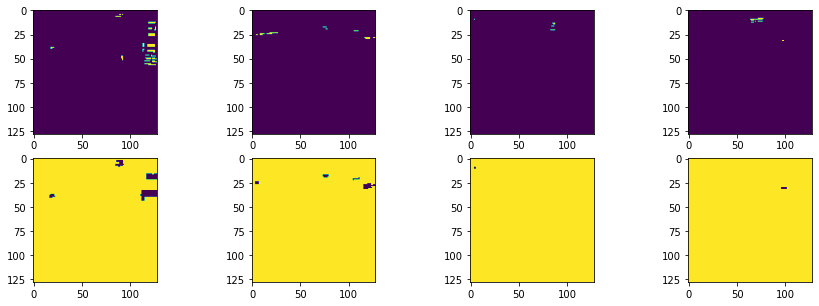

Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-11-c1362dae5958>", line 99, in generator
    score_map, geo_map, training_mask,rbox,rectangles = generate_r((new_h, new_w), text_polys, text_tags,min_text_size)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


In [12]:

font = cv2.FONT_HERSHEY_SIMPLEX
dg = get_batch(num_workers=1, input_size=512, batch_size=10,min_text_size=4)
for iter in range(4):
        print("iter: ", iter)
        data = next(dg)
        imgs = data[0]
        imgs_name = data[1]
        polygons = data[-3]
        labels = data[-2]
        masks = data[6]
        prev_start_index = 0
       
        
        for i, (img, mask, img_name) in enumerate(zip(imgs, masks, imgs_name)):
            # img_name = ''
            im = img.copy()
            poly_start_index = len(masks[i-1])
            poly_end_index = len(masks[i-1]) + len(mask)
            for poly, la,  in zip(polygons[prev_start_index:(prev_start_index+len(mask))], labels[prev_start_index:prev_start_index+len(mask)]):
                cv2.polylines(img, [poly.astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
                # trans = ground_truth_to_word(la)
                # img_name = img_name + trans + '_'
            img_name = img_name[:-4] + '.jpg'
            cv2.imwrite("./polygons/" + os.path.basename(img_name), img)
          
            prev_start_index += len(mask)
        print(data[4][1].shape)
# train_dataloader = Dataloder(train_dataset, batch_size=10, shuffle=True)   

fig, ax = plt.subplots(2,4,figsize=(15,5))
for j in range(4):
                ax[1,j].imshow(data[4][j])
                ax[0,j].imshow(data[2][j])
            
                
plt.show()

In [22]:
data[0][1].shape

(512, 512, 3)

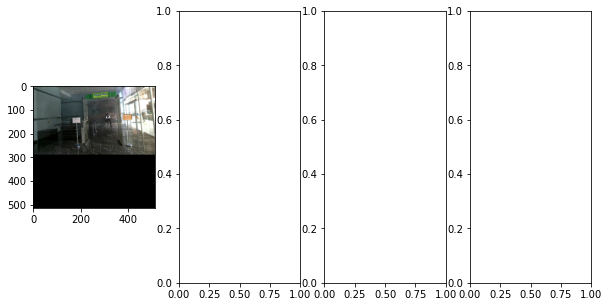

In [38]:
fig, ax = plt.subplots(1,4,figsize=(10,5))
for j in range(4):

                ax[0].imshow(data[0][3]/255)

In [15]:
data[-1]

[]

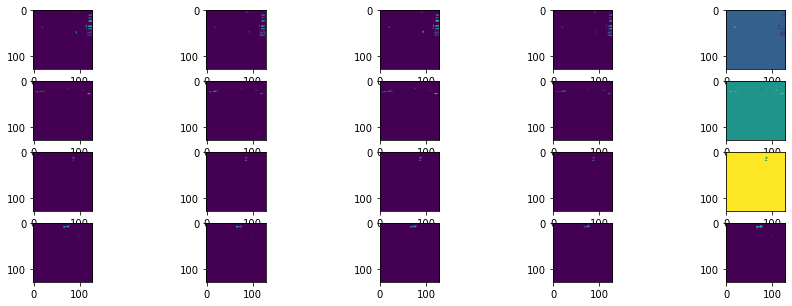

In [27]:
fig, ax = plt.subplots(4,5,figsize=(15,5))
for j in range(4):
    for i in range(5):
                ax[j,i].imshow(data[3][j][:,:,i])
            
            
                
plt.show()

In [ ]:
data[-1]

In [ ]:
plt.imshow(imgs[1])

In [ ]:
g=return_names('C:\\Users\\Abhi\\Desktop\\CS2\\polygons\\','JPG')


In [ ]:

fig, ax = plt.subplots(1,3,figsize=(15,5))
for j in range(3):
                ax[j].imshow(cv2.imread(g['JPG'][j+4]))
plt.show()

# SYnth DATA

In [ ]:
# https://github.com/RaidasGrisk/tf2-fots/blob/master/synthtext.py

In [ ]:

dataset = scipy.io.loadmat('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\SynthText\\gt.mat')

# # 1. paths to imgs
img_paths = [i[0] for i in dataset['imnames'][0, :]]
with open('synthtext/path_to_imgs.txt', 'w') as f:
    for item in img_paths:
        f.write("%s\n" % item)

# 2. word list
dataset_word_list = []
for img_words in dataset['txt'][0, :]:
    img_word_list = []
    for words in img_words:
        for word in [item for sublist in [i.strip().split(' ') for i in words.split('\n')] for item in sublist]:
            if word != '':
                img_word_list.append(word)
    dataset_word_list.append(img_word_list)

# 3. polys and words
iter = 0
for polys, words, img_path in zip(dataset['wordBB'][0, :], dataset_word_list, img_paths):

    # fix poly
    if len(polys.shape) == 2:
        polys = polys[:, :, np.newaxis]
    polys = polys.transpose([-1, 0, 1])

    # check if all match up
    if polys.shape[0] != len(words):
        print('number of polys and words do not mathc')
        break

    # write file
    with open('synthtext/annotation/{}.txt'.format(img_path.split('/')[1].split('.')[0]), 'w') as f:
        for poly, word in zip(polys, words):
            line = np.around(poly, 1).ravel()
            line = np.concatenate([line, [word]], axis=0)
            for item in line:
                f.write("%s " % item)
            f.write("\n")

    iter += 1
    if iter % 100 == 0:
        print(iter, 'out of', len(img_paths))

In [ ]:
CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-~`´<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
def label_to_array(label):
    try:
        label = label.replace(' ', '')
        return [CHAR_VECTOR.index(x) for x in label]
    except Exception as ex:
        print(label)
        raise ex

def generator_synth( input_size=512, batch_size=12,min_text_size=10):
    file=open('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\path_to_imgs.txt')
    image_list=[]
    for v in file.readlines():
        image_list.append('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\SynthText\\'+v.replace('\n',''))
        
    index = np.arange(0, len(image_list))
    while True:
        np.random.shuffle(index)
        batch_images = []
        batch_image_fns = []
        batch_score_maps = []
        batch_geo_maps = []
        batch_training_masks = []

        batch_text_polyses = [] 
        batch_text_tagses = []
        batch_boxes_masks = []

        batch_text_labels = []
        count = 0
        for i in index:
            try:
                im_fn = image_list[i]
                im=cv2.imread(im_fn)
                
                poly, text_tags, labels=load_annoataion('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\annotation\\'+image_list[i].split('/')[1].split('.')[0]+'.txt')
            
                h,w=im.shape[0],im.shape[1]
                poly, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

                ############################# Data Augmentation ##############################
                # random scale this image
               
                scale=random.choice((.8,1,2))
                im = cv2.resize(im, dsize=None, fx=scale, fy=scale)
                text_polys = poly*scale
              
#                 rotate image from [-10, 10]
#                 angle=random.randint(-10,10)
#                 im, text_polys = rotate_image(im, text_polys, angle)
               
                # 600×600 random samples are cropped.
                im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
                # im, text_polys, text_tags, selected_poly = crop_area_fix(im, text_polys, text_tags, crop_size=(600, 600))
                text_labels = [text_labels[i] for i in selected_poly]
                if text_polys.shape[0] == 0 or len(text_labels) == 0:
                    continue

                # pad the image to the training input size or the longer side of image
                new_h, new_w, _ = im.shape
                max_h_w_i = np.max([new_h, new_w, input_size])
                im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
                im_padded[:new_h, :new_w, :] = im.copy()
                im = im_padded
                # resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(resize_w, resize_h))
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox,rectangles  = generate_rbox_1((new_h, new_w), text_polys, text_tags,min_text_size)
#                 mask = [not (word == [-1]) for word in text_labels]
#                 text_labels = list(compress(text_labels, mask))
#                 rectangles = list(compress(rectangles, mask))
                mask1 = [not (word == [-1]) for word in text_labels]
                mask2 = [j[1] > min_text_size and j[0] > min_text_size for j in [i[2::] for i in rbox[1]]]  # make sure the text is at least 4x4 pixels
                mask = [True if i and j else False for (i, j) in zip(mask1, mask2)]
                text_labels = list(compress(text_labels, mask))
                rectangles = list(compress(rectangles, mask))
                rbox = tuple([list(compress(item, mask)) for item in rbox])
              
                assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

                if len(text_labels) == 0:
                    continue

                boxes_mask = np.array([count] * len(rectangles))

                count += 1

                batch_images.append(im[:, :, ::-1].astype(np.float32))
              
                batch_image_fns.append(im_fn)
                batch_score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                batch_geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                batch_training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))

                batch_text_polyses.append(rectangles)
                batch_boxes_masks.append(boxes_mask)
                batch_text_labels.extend(text_labels)
                batch_text_tagses.append(text_tags)
                if len(batch_images) == batch_size:
                    batch_text_polyses = np.concatenate(batch_text_polyses)
                    batch_text_tagses = np.concatenate(batch_text_tagses)
                    batch_transform_matrixes, batch_box_widths = get_project_matrix_and_width(batch_text_polyses, batch_text_tagses)
                   
                    batch_text_labels_sparse = sparse_tuple_from(np.array(batch_text_labels))

                    # yield images, image_fns, score_maps, geo_maps, training_masks
                    yield batch_images, batch_image_fns, batch_score_maps, batch_geo_maps, batch_training_masks, batch_transform_matrixes, batch_boxes_masks, batch_box_widths, batch_text_labels_sparse, batch_text_polyses, batch_text_labels
                    batch_images = []
                    batch_image_fns = []
                    batch_score_maps = []
                    batch_geo_maps = []
                    batch_training_masks = []
                    batch_text_polyses = [] 
                    batch_text_tagses = []
                    batch_boxes_masks = []
                    batch_text_labels = []
                    count = 0
            except Exception as e:
                import traceback
              
                traceback.print_exc()
                continue

In [ ]:
def load_annoataion(p):
    '''
    load annotation from the text file
    :param p:
    :return:
    '''
    # print p
    text_polys = []
    text_tags = []
    labels = []
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32)
    with open(p, 'r', encoding='utf-8-sig') as f:
        for line in f.readlines():
            # strip BOM. \ufeff for python3,  \xef\xbb\bf for python2
            # line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]
            line = line.replace('\xef\xbb\bf', '')
            line = line.replace('\xe2\x80\x8d', '')
            line = line.strip()
            line = line.split(' ')
            if len(line) > 9:
                label = line[8]
                for i in range(len(line) - 9):
                    label = label + "," + line[i + 9]
            else:
                label = line[-1]
            # label = line[-1]
            line = [line[0]] + [line[4]] + [line[1]] + [line[5]] + [line[2]] + [line[6]] + [line[3]] + [line[7]]
            temp_line = map(eval, line[:8])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, temp_line)
            # x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            if label == '*' or label == '###' or label == '':
                text_tags.append(True)
                labels.append([-1])
            else:
                labels.append(label_to_array(label))
                text_tags.append(False)
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool), labels

In [ ]:
def get_batch_synth(num_workers, **kwargs):
    try:
        enqueuer = GeneratorEnqueuer(generator_synth(**kwargs), use_multiprocessing=False)
        enqueuer.start(max_queue_size=10, workers=num_workers)
        generator_output = None
        while True:
            while enqueuer.is_running():
                if not enqueuer.queue.empty():
                    generator_output = enqueuer.queue.get()
                    break
                else:
                    time.sleep(0.01)
            yield generator_output
            generator_output = None
    finally:
        if enqueuer is not None:
            enqueuer.stop()

In [ ]:

font = cv2.FONT_HERSHEY_SIMPLEX
dg = get_batch_synth(num_workers=1, input_size=640, batch_size=10)
for iter in range(6):
        print("iter: ", iter)
        data = next(dg)
        imgs = data[0]
        imgs_name = data[1]
        polygons = data[-2]
        labels = data[-1]
        masks = data[6]
        prev_start_index = 0
        for i, (img, mask, img_name) in enumerate(zip(imgs, masks, imgs_name)):
            # img_name = ''
            im = img.copy()
            poly_start_index = len(masks[i-1])
            poly_end_index = len(masks[i-1]) + len(mask)
            for poly, la,  in zip(polygons[prev_start_index:(prev_start_index+len(mask))], labels[prev_start_index:prev_start_index+len(mask)]):
                cv2.polylines(img, [poly.astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
                # trans = ground_truth_to_word(la)
                # img_name = img_name + trans + '_'
            img_name = img_name[:-4] + '.jpg'
            cv2.imwrite("./polygons/" + os.path.basename(img_name), img)
          
            prev_start_index += len(mask)
        print(data[4][1].shape)
       
fig, ax = plt.subplots(2,4,figsize=(15,5))
for j in range(4):
                ax[1,j].imshow(data[4][j])
                ax[0,j].imshow(data[2][j])
plt.show()

In [ ]:
g=return_names('C:\\Users\\Abhi\\Desktop\\CS2\\polygons\\','JPG')
fig, ax = plt.subplots(1,3,figsize=(15,5))
for j in range(3):
                ax[j].imshow(cv2.imread(g['JPG'][j+10]))
plt.show()